The First thing that is necessary in a scenario is to set up the world and the physics (limited "physics" in this problem)

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# --- Custom Environment: Cliff Walking with Two Cookies ---
class CliffWalkingCookies:
    def __init__(self, rows=4, cols=12):
        self.rows = rows
        self.cols = cols
        self.start = (3, 0)
        self.cookie1 = (1, 5)
        self.goal = (3, 11)
        self.cliff = [(3, c) for c in range(1, 11)]
        self.action_space = [0, 1, 2, 3]  # up, right, down, left
        self.reset()

    def reset(self):
        self.state = (self.start, False)  # (position, has_cookie1)
        return self.state

    def step(self, action):
        (r, c), has_cookie1 = self.state

        # Move
        if action == 0: r = max(r - 1, 0)       # Up
        elif action == 1: c = min(c + 1, self.cols - 1)  # Right
        elif action == 2: r = min(r + 1, self.rows - 1)  # Down
        elif action == 3: c = max(c - 1, 0)       # Left

        new_pos = (r, c)
        reward = -1  # default step cost
        done = False

        if new_pos in self.cliff:
            reward = -100
            done = True
            new_pos = self.start
            has_cookie1 = False  # reset cookie progress
        elif new_pos == self.cookie1 and not has_cookie1:
            reward = 100
            has_cookie1 = True
        elif new_pos == self.goal:
            if has_cookie1:
                reward = 110
                done = True
            else:
                reward = -10  # reached goal too early

        self.state = (new_pos, has_cookie1)
        return self.state, reward, done

Now you need to define your q-learning controller and your reward function (the reward function is extremely important)
You should try using multiple reward functions to see how each performs and consider tuning the values within each


Training complete.
Average reward: 143.84
Average steps per episode: 16.38
Cliff falls: 419
Early goal penalties (missed first cookie): 0
Successful full runs (both cookies): 1581
Success rate: 79.0%


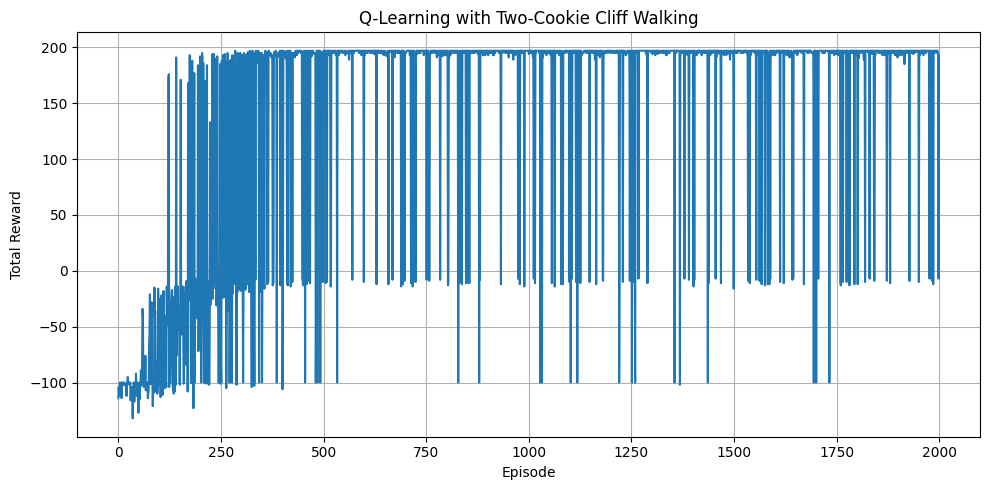

In [11]:
# --- Q-Learning Setup ---
env = CliffWalkingCookies()
alpha = 0.1
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.05
n_episodes = 2000

# Initialize Q-table
Q = {}
for r in range(env.rows):
    for c in range(env.cols):
        for has_cookie in [False, True]:
            Q[((r, c), has_cookie)] = np.zeros(4)

# Tracking stats
episode_returns = []
episode_lengths = []
successful_runs = 0
early_goal_penalty = 0
cliff_falls = 0

# --- Q-Learning Loop ---
for ep in range(n_episodes):
    state = env.reset()
    total_reward = 0
    steps = 0
    done = False

    while not done:
        if np.random.rand() < epsilon:
            action = np.random.choice(env.action_space)
        else:
            action = np.argmax(Q[state])

        next_state, reward, done = env.step(action)

        Q[state][action] += alpha * (
            reward + gamma * np.max(Q[next_state]) - Q[state][action]
        )

        # Track outcomes
        if reward == -100:
            cliff_falls += 1
        elif reward == -10:
            early_goal_penalty += 1
        elif reward == 110:
            successful_runs += 1

        total_reward += reward
        steps += 1
        state = next_state

    episode_returns.append(total_reward)
    episode_lengths.append(steps)
    epsilon = max(epsilon * epsilon_decay, epsilon_min)

# --- Print Results ---
print("\nTraining complete.")
print(f"Average reward: {np.mean(episode_returns):.2f}")
print(f"Average steps per episode: {np.mean(episode_lengths):.2f}")
print(f"Cliff falls: {cliff_falls}")
print(f"Early goal penalties (missed first cookie): {early_goal_penalty}")
print(f"Successful full runs (both cookies): {successful_runs}")
print(f"Success rate: {successful_runs / n_episodes * 100:.1f}%")

# --- Plot Results ---
plt.figure(figsize=(10, 5))
plt.plot(episode_returns)
plt.title("Q-Learning with Two-Cookie Cliff Walking")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.tight_layout()
plt.show()